# Rail Ridership 
## Seoul

Hello, Audrey here. In this Jupyter notebook I will explore Seoul ridership data, and identify stations with the highest ridership. 

We use data provided by the Seoul Metropolitan government. This dataset provides the count of riders getting on and off at each station using prepaid and one-time transit cards. 

Data: [서울시 지하철호선별 역별 승하차 인원 정보](http://data.seoul.go.kr/dataList/OA-12914/S/1/datasetView.do)

In [2]:
import urllib.request, json 
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

In [3]:
s_ride = gpd.read_file('AYJ-GroupData/CARD_SUBWAY_MONTH_202012.csv')
s_ride

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,geometry
0,20201201,8호선,가락시장,7050,7931,20201204,None
1,20201201,8호선,석촌,6902,7846,20201204,None
2,20201201,8호선,잠실(송파구청),11865,13466,20201204,None
3,20201201,8호선,몽촌토성(평화의문),4986,5191,20201204,None
4,20201201,8호선,강동구청,9548,10062,20201204,None
...,...,...,...,...,...,...,...
18513,20201231,경의선,신촌,541,633,20210103,None
18514,20201231,경의선,서울역,2512,3329,20210103,None
18515,20201231,경원선,소요산,1522,1401,20210103,None
18516,20201231,경원선,동두천,1379,1589,20210103,None


Renaming columns to be in English:

In [5]:
list(s_ride)

['사용일자', '노선명', '역명', '승차총승객수', '하차총승객수', '등록일자', 'geometry']

In [6]:
s_ride.columns = ['Date Use', 'Rail Line', 'Station', 'Onboarding Rider Count', 'Offboarding Rider Count', 'Recording Date', 'geometry']

In [19]:
s_ride.head()

,Date Use,Rail Line,Station,Onboarding Rider Count,Offboarding Rider Count,Recording Date,geometry
0,20201201,8호선,가락시장,7050.0,7931.0,20201204,None
1,20201201,8호선,석촌,6902.0,7846.0,20201204,None
2,20201201,8호선,잠실(송파구청),11865.0,13466.0,20201204,None
3,20201201,8호선,몽촌토성(평화의문),4986.0,5191.0,20201204,None
4,20201201,8호선,강동구청,9548.0,10062.0,20201204,None


Let's see what type the Rider Count columns are, and convert to floats. 

In [8]:
s_ride.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18518 entries, 0 to 18517
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Date Use                 18518 non-null  object  
 1   Rail Line                18518 non-null  object  
 2   Station                  18518 non-null  object  
 3   Onboarding Rider Count   18518 non-null  object  
 4   Offboarding Rider Count  18518 non-null  object  
 5   Recording Date           18518 non-null  object  
 6   geometry                 0 non-null      geometry
dtypes: geometry(1), object(6)
memory usage: 1012.8+ KB


In [11]:
s_ride["Onboarding Rider Count"] = pd.to_numeric(s_ride["Onboarding Rider Count"], downcast="float")
s_ride.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18518 entries, 0 to 18517
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Date Use                 18518 non-null  object  
 1   Rail Line                18518 non-null  object  
 2   Station                  18518 non-null  object  
 3   Onboarding Rider Count   18518 non-null  float32 
 4   Offboarding Rider Count  18518 non-null  object  
 5   Recording Date           18518 non-null  object  
 6   geometry                 0 non-null      geometry
dtypes: float32(1), geometry(1), object(5)
memory usage: 940.5+ KB


In [12]:
s_ride["Offboarding Rider Count"] = pd.to_numeric(s_ride["Offboarding Rider Count"], downcast="float")
s_ride.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18518 entries, 0 to 18517
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Date Use                 18518 non-null  object  
 1   Rail Line                18518 non-null  object  
 2   Station                  18518 non-null  object  
 3   Onboarding Rider Count   18518 non-null  float32 
 4   Offboarding Rider Count  18518 non-null  float32 
 5   Recording Date           18518 non-null  object  
 6   geometry                 0 non-null      geometry
dtypes: float32(2), geometry(1), object(4)
memory usage: 868.2+ KB


Now I'm going to calculate summary stats to filter the data by highest counts. 

In [13]:
s_ride[["Onboarding Rider Count", "Offboarding Rider Count"]].describe()

,Onboarding Rider Count,Offboarding Rider Count
count,18518.000000,18518.000000
mean,7566.791992,7542.223633
std,7702.103027,7746.147461
min,1.000000,0.000000
25%,2413.000000,2371.000000
50%,5260.000000,5194.500000
75%,10040.500000,9877.500000
max,74698.000000,70337.000000


The columns are approximately the same. I'll use Onboarding Rider Count for the rest of the analysis. 

Filtering to find the top ridership counts:

In [22]:
top = s_ride.sort_values(by=['Onboarding Rider Count'], ascending = False)
top

,Date Use,Rail Line,Station,Onboarding Rider Count,Offboarding Rider Count,Recording Date,geometry
2179,20201204,2호선,강남,74698.0,70337.0,20201207,None
234,20201201,2호선,강남,71889.0,69871.0,20201204,None
652,20201202,2호선,강남,71388.0,67461.0,20201205,None
1761,20201203,2호선,강남,70117.0,66520.0,20201206,None
3588,20201207,2호선,강남,69232.0,67727.0,20201210,None
...,...,...,...,...,...,...,...
2141,20201204,6호선,연신내,1.0,0.0,20201207,None
3783,20201207,6호선,연신내,1.0,0.0,20201210,None
623,20201202,분당선,복정,1.0,0.0,20201205,None
10699,20201218,일산선,지축,1.0,0.0,20201221,None


Gangnam Station Line 2 has the highest onboarding rider count. 

In [23]:
top2 = s_ride.sort_values(by=['Offboarding Rider Count'], ascending = False)
top2

,Date Use,Rail Line,Station,Onboarding Rider Count,Offboarding Rider Count,Recording Date,geometry
2179,20201204,2호선,강남,74698.0,70337.0,20201207,None
234,20201201,2호선,강남,71889.0,69871.0,20201204,None
3588,20201207,2호선,강남,69232.0,67727.0,20201210,None
652,20201202,2호선,강남,71388.0,67461.0,20201205,None
1761,20201203,2호선,강남,70117.0,66520.0,20201206,None
...,...,...,...,...,...,...,...
16243,20201228,6호선,신내,1.0,0.0,20201231,None
10074,20201217,3호선,충무로,2.0,0.0,20201220,None
16172,20201228,3호선,충무로,1.0,0.0,20201231,None
3946,20201207,경원선,창동,1.0,0.0,20201210,None


Same for offboarding. Now what LA neighborhood should we look at? 

## Los Angeles 

Unfortunately, we don't yet have ridership data on the station level for Los Angeles. 
I did submit a public records request. 

However, other people have done this analysis and found the highest ridership at the following stations: 
* 7th Street/Metro Center Station
* Union Station (sort of obvious)
* North Hollywood Station 
* Pershing Square Station 
* Wilshire Vermont Station 

We'll analyze DTLA and maybe North Hollywood for neighborhood paired analysis. 

Source: https://la.streetsblog.org/2019/08/30/looking-for-trends-in-metros-latest-rail-ridership-numbers/


## Next Steps: 

### Try using API 

I wanted to try using an API, but as a non-resident it's super difficult for me to get access to Seoul's Open API data. ;; 
So I'll walk through Week 5 lab with metro data and later substitute in Seoul's API url once Shinah gets access. 

In [21]:
# api url  
s_url = 'http://openapi.seoul.go.kr:8088/(인증키)/xml/CardSubwayStatsNew/1/5/20151101'

# call the api and bring the data in
with urllib.request.urlopen(s_url) as url:
    data = json.loads(url.read().decode())

# convert the data to a dataframe
df1 = pd.json_normalize(data, 'items')
df1

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)>

For LA, is there a way to convert an ISOTP site to an API site? 

In [24]:
# api url  
l_url = 'https://isotp.metro.net/MetroRidership/Index.aspx'

# call the api and bring the data in
with urllib.request.urlopen(l_url) as url:
    data = json.loads(url.read().decode())

# convert the data to a dataframe
df1 = pd.json_normalize(data, 'items')
df1

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1123)>

### Map it! 

We need to join the ridership data to station shapefiles. 

Playing with Seoul's data: 

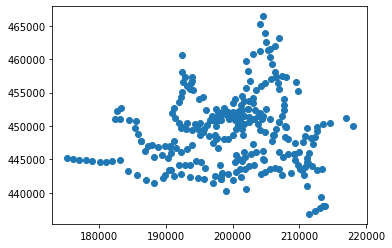

In [15]:
s_georide = gpd.read_file('AYJ-GroupData/subway_address_20201109.shp')
s_georide.plot()

In [16]:
s_georide.head()

,geometry
0,POINT (197343.000 450729.000)
1,POINT (198018.000 451601.000)
2,POINT (198343.000 452018.000)
3,POINT (199427.000 452011.000)
4,POINT (199999.000 452079.000)


In [18]:
s_georide2 = gpd.read_file('AYJ-GroupData/CARD_SUBWAY_MONTH_202012_V2.csv') 
s_georide2.head()

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,ridership,st_nm,geometry
0,20201201,8호선,가락시장,7050,7931,20201204,14981,가락시장(8)역,None
1,20201201,8호선,석촌,6902,7846,20201204,14748,석촌(8)역,None
2,20201201,8호선,잠실(송파구청),11865,13466,20201204,25331,잠실(8)역,None
3,20201201,8호선,몽촌토성(평화의문),4986,5191,20201204,10177,몽촌토성(8)역,None
4,20201201,8호선,강동구청,9548,10062,20201204,19610,강동구청(8)역,None
